In [1]:
import pandas
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
trainData = pandas.read_csv("NHANES_Data_P1_MI_train.csv")
testData = pandas.read_csv("NHANES_Data_P1_MI_test.csv")

In [3]:
# Remove rows that have missing "MI"
trainData = trainData.dropna(subset=["MI"])

# drop columns that are not needed
trainData = trainData.drop(columns = ["ID", "Income", "Edu", "Insurance"])


In [4]:
# clean data
imputer = KNNImputer(n_neighbors=10)
imputerTrainData = imputer.fit_transform(trainData)

imputerTrainData = pandas.DataFrame(imputerTrainData, columns=trainData.columns)

In [5]:
# Prepare the data
x = imputerTrainData[["Sex", "Age", "Race", "Systolic", "Diastolic", "Pulse", "BMI", "HDL", "Trig", "LDL", "TCHOL", "eGFR", "CurrentSmoker", "Diabetes"]]
y = imputerTrainData[["MI"]]


In [6]:
# split the data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# scale data
scaler = RobustScaler()
# fit_transform for train and transform for test
scaledXTrainData = scaler.fit_transform(xTrain)
scaledXTestData = scaler.transform(xTest)

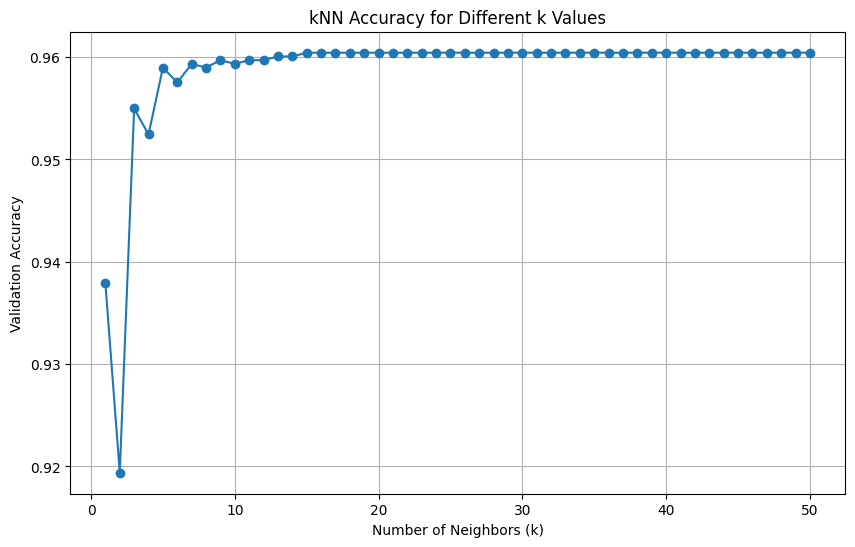

Best k value: 15 with accuracy: 0.9604


In [ ]:
# find the best k value and plot the accuracies of eack k
kRange = range(1, 51)
accuracies = []
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaledXTrainData, yTrain.values.ravel())
    score = knn.score(scaledXTestData, yTest.values.ravel())
    accuracies.append(score)

plt.figure(figsize=(10,6))
plt.plot(kRange, accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.title('kNN Accuracy for Different k Values')
plt.grid(True)
plt.show()

bestK = kRange[accuracies.index(max(accuracies))]
print(f'Best k value: {bestK} with accuracy: {max(accuracies):.4f}')

In [9]:
# create and train the model
KNN = KNeighborsClassifier(n_neighbors=bestK)

KNN.fit(scaledXTrainData, yTrain.values.ravel())

# print('score:', KNN.score(scaledXTestData, yTest.values.ravel()))

pp = KNN.predict_proba(scaledXTestData)

print('\n', pp)


 [[0.  1. ]
 [0.  1. ]
 [0.  1. ]
 ...
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]]


In [10]:
testData = testData.drop(columns = ["Income", "Edu", "Insurance"])

# Impute missing values in testData using the same imputer as trainData
imputedTestData = imputer.fit_transform(testData)

imputedTestData = pandas.DataFrame(imputedTestData, columns=testData.columns)

# Select features for prediction (same as x)
xTestData = imputedTestData[["Sex", "Age", "Race", "Systolic", "Diastolic", "Pulse", "BMI", "HDL", "Trig", "LDL", "TCHOL", "eGFR", "CurrentSmoker", "Diabetes"]]

# Scale test data using the fitted scaler
scaledXTestDataForPrediction = scaler.transform(xTestData)

# Predict probabilities
mi_prob = knn.predict_proba(scaledXTestDataForPrediction)[:, 1]


# Add probability column to imputedTestData
imputedTestData["MI_Probability"] = mi_prob

finalData = imputedTestData[["ID", "MI_Probability"]]

# Save to CSV
finalData.to_csv("test_with_prob.csv", index=False)
